In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #for debugging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    # print("q1 shape is ",Q1.shape)
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    # print("qtil and Rtil")
    # print(Qtil.shape, Rtil.shape)
    first = np.vstack((np.matmul(np.matmul(2*Qtil.T, Q1.T),b)))
    # print("first shape")
    # print(first.shape)
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T, d, rcond=None)[0])))
    k = npl.lstsq(Rtil, denom, rcond=None)[0]
    return npl.lstsq(R, np.vstack(np.matmul(Q1.T, b)) - np.matmul(Q2.T , k)/2, rcond=None)[0]
def lqe(A, B, C,G, y1, T, lam,rcond):
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    shape1 = (T * p, m*(T-1))
    Atil_top = np.kron(np.eye(T), C)  # This is 200 x 400
    Additional_matrix = np.random.rand(T * p, (T * p) - 6)  # Adjust dimensions to match Atil_top width

# Ensure the zeros array used in the concatenation below is of correct dimensions
    zeros_shape = (T * p, m * (T - 1))
    Atil_top_extended = np.hstack((Atil_top, Additional_matrix))

# Review dimensions for the block operation
    Atil = np.block([[Atil_top_extended, np.zeros(zeros_shape)],[np.zeros((m * (T - 1), Atil_top_extended.shape[1])), np.sqrt(lam) * np.eye(m * (T - 1))]])
    # print(Atil.shape,"#########")
    y_flat = y1.T.flatten()
    zeros_part = np.zeros(m * (T-1))
    btil = np.concatenate((y_flat, zeros_part)).reshape(-1, 1)
    # print(btil.shape)
    Ctil = np.block([
    [np.kron(np.eye(T-1), A) - np.eye(n * (T-1 ), k=n), np.kron(np.eye(T-1), G), np.kron(np.eye(T-1), B)]])
    print(Ctil.shape,"####")
    dtil = np.zeros(n * (T - 1))
    # print(dtil.shape)
    z = cls_solve(Atil, btil, Ctil, dtil)
    x_hat = [z[i * n:(i + 1) * n] for i in range(T)]
    u_hat_start_index = T * n
    u_hat_end_index = u_hat_start_index + (T)
    u_hat = [z[u_hat_start_index + i : u_hat_start_index + (i + 1) ] for i in range((T - 1) * 2)]
    w_hat_start_index = u_hat_end_index
    w_hat_end_index = w_hat_start_index + (T - 1) * p
    w_hat = [z[w_hat_start_index + i * p: w_hat_start_index + (i + 1) * p] for i in range((T - 1) * 2)]
    return x_hat,u_hat,z,w_hat,Atil,btil
### ALL THE INPUT CASES###
lambda_values = np.logspace(-4,6, num=20)
def calculate_x_next(t, x, w, A, B, G, u):
    # Base case: ensure initial state is returned as a column vector
    if t == 0:
        return np.array(x[0]).reshape(-1, 1)

    # Check if state at time t has already been calculated
    if len(x) > t:
        return np.array(x[t]).reshape(-1, 1)

    # Recursive call to get the previous state
    x_prev = calculate_x_next(t - 1, x, w, A, B, G, u)

    # Process noise and control input for the current timestep
    w_t = np.array(w[t - 1]).reshape(-1, 1)
    u_t = np.array([u[t - 1]] if t - 1 < len(u) else [0]).reshape(-1, 1)

    # State update equation
    x_t = A @ x_prev + B @ w_t + G @ u_t

    # Append the newly calculated state to the state vector list
    x.append(x_t.flatten())  # Store as a 1D array for easier handling

    # Return the new state as a column vector
    return x_t



############## Input Cases#################
T = 80
# A = np.block([[np.eye(2), np.eye(2)], [np.zeros((2, 2)), np.eye(2)]])
A = np.array([[0.9, 0, 1, 0],
              [0, 0.9, 0, 1],
              [0, 0, 0.9, 0],
              [0, 0, 0, 0.9]])
B = np.block([[np.zeros((2, 2))], [np.eye(2)]])
C = np.block([[np.eye(2), np.zeros((2, 2))]])
# C=np.eye(4)
G = np.random.rand(4, 2)
n, m, K = A.shape[0], B.shape[1], C.shape[0]
P = np.eye(m)
R = np.eye(K)*2
Q = np.eye(n)*0.5

w = [np.random.multivariate_normal(mean=np.zeros(m), cov=P) for _ in range(T)]
w_array=np.array(w)
print(w_array.shape,"w shape")
v = [np.random.multivariate_normal(mean=np.zeros(K), cov=R) for _ in range(T)]
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]
A_sin = 1
f_sin = 0.2
phi_sin = 0
m = 2        # Dimension of the multivariate Gaussian noise

sinusoidal_input = A_sin * np.sin(2 * np.pi * f_sin * np.arange(T) + phi_sin)
P = np.eye(m) # Covariance matrix P for the Gaussian noise
gaussian_noise = np.random.multivariate_normal(mean=np.zeros(m), cov=P, size=T)
sinusoidal_input = sinusoidal_input.reshape(T, 1)
u = np.hstack((sinusoidal_input, gaussian_noise[:, 0:1]))

# Reshape u to ensure each u_t is (2, 1) at each time step
u = u.reshape(T, 2, 1)
print("u.shape is")
print(len(u))
print("##############")

# Initialize the state list with the initial condition
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Calculate x for eZach timestep up to T
for t in range(1, T + 1):
    # print(f'Calculating state at time {t}')  # Debug print
    calculate_x_next(t, x, w, A, B, G, u)

# Convert the list of states to a numpy array for easier handling
x_array = np.array(x)
print(x_array.shape,"x_array shape")
y = [C @ x_array[t] + v[t] for t in range(T)]
y1 = np.concatenate(y)
# rcond=-1
# type(y1)
y=np.array(y1)
print(y.shape)
# type(y)
# print(y.shape)
lam = 1e+3 # lamda value is assigned as 10^3
rcond=-1
x_hat,u_hat,z,w_hat,Atil,btil = lqe(A, B, C,G, y, T, lam,rcond)
# print(type(z))
print(z.shape,"shape of z")
x_hat=np.array(x_hat)
print(x_hat.shape,"xhat shape")
u_hat=np.array(u_hat)
print(type(u_hat))
# print(u_hat)
print(u_hat.shape,"uhat shape")

print("##########")
print(len(w_hat),"w_hat shape")
# print(u_hat)

(80, 2) w shape
u.shape is
80
##############
(81, 4) x_array shape
(160,)
(316, 632) ####
(632, 1) shape of z
(80, 4, 1) xhat shape
<class 'numpy.ndarray'>
(158, 1, 1) uhat shape
##########
158 w_hat shape


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract strong correlations
def identify_strong_correlations(correlation_matrix, threshold=0.8):
    n = correlation_matrix.shape[0]
    strong_pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            if abs(correlation_matrix[i, j]) > threshold:
                strong_pairs.append((i, j, correlation_matrix[i, j]))
    return strong_pairs

# Function to visualize correlations between identified pairs
def plot_correlated_states(x_hat, pairs, time_steps):
    plt.figure(figsize=(12, 6))
    for idx, (i, j, corr) in enumerate(pairs):
        plt.plot(range(time_steps), x_hat[:, i], label=f"State {i}")
        plt.plot(range(time_steps), x_hat[:, j], label=f"State {j}")
        plt.title(f"State Pair ({i}, {j}) with Correlation {corr:.2f}")
        plt.xlabel("Time Step")
        plt.ylabel("State Value")
        plt.legend()
        plt.show()

# Function to analyze system dynamics
def analyze_system_dynamics(A, B, C, G, strong_pairs):
    print("Analyzing System Dynamics for Strongly Correlated Pairs:")
    for i, j, corr in strong_pairs:
        print(f"\nState Pair ({i}, {j}) with Correlation {corr:.2f}:")

        # Check coupling in A
        if i < A.shape[0] and j < A.shape[0]:
            if A[i, j] != 0 or A[j, i] != 0:
                print(f"  Coupled in A: A[{i},{j}] = {A[i,j]}, A[{j},{i}] = {A[j,i]}")
            else:
                print("  No strong coupling in A.")
        else:
            print("  Indices out of bounds for A.")

        # Check influence of B
        if i < B.shape[1] and j < B.shape[1]:
            if np.any(B[:, i]) or np.any(B[:, j]):
                print(f"  B influences these states: B[:,{i}] = {B[:,i]}, B[:,{j}] = {B[:,j]}")
            else:
                print("  No significant influence from B.")
        else:
            print("  Indices out of bounds for B.")

        # Check observation overlap in C
        if i < C.shape[1] and j < C.shape[1]:
            if np.any(C[:, i]) or np.any(C[:, j]):
                print(f"  C maps these states: C[:,{i}] = {C[:,i]}, C[:,{j}] = {C[:,j]}")
            else:
                print("  No significant observation mapping in C.")
        else:
            print("  Indices out of bounds for C.")

        # Check control input overlap in G
        if i < G.shape[1] and j < G.shape[1]:
            if np.any(G[:, i]) or np.any(G[:, j]):
                print(f"  G links these states: G[:,{i}] = {G[:,i]}, G[:,{j}] = {G[:,j]}")
            else:
                print("  No significant control linkage in G.")
        else:
            print("  Indices out of bounds for G.")


# Function to modify the model for better behavior
def modify_model(A, B, C, G, strong_pairs, decoupling_factor=0.5):
    # Decouple states in A
    for i, j, _ in strong_pairs:
        # Modify A if indices are within bounds
        if i < A.shape[0] and j < A.shape[0]:
            A[i, j] *= decoupling_factor
            A[j, i] *= decoupling_factor

        # Modify B if indices are within bounds
        if i < B.shape[1] and j < B.shape[1]:
            B[:, i] *= decoupling_factor
            B[:, j] *= decoupling_factor

        # Modify C if indices are within bounds
        if i < C.shape[1] and j < C.shape[1]:
            C[:, i] *= decoupling_factor
            C[:, j] *= decoupling_factor

        # Modify G if indices are within bounds
        if i < G.shape[1] and j < G.shape[1]:
            G[:, i] *= decoupling_factor
            G[:, j] *= decoupling_factor

    return A, B, C, G



# Example Workflow
def main_workflow(x_hat, A, B, C, G, correlation_threshold=0.8, time_steps=80):
    # Step 1: Calculate correlation matrix
    correlation_matrix = np.corrcoef(x_hat.T)

    # Step 2: Identify strong correlations
    strong_pairs = identify_strong_correlations(correlation_matrix, threshold=correlation_threshold)
    print(f"Strongly Correlated Pairs (Threshold {correlation_threshold}): {strong_pairs}")

    # Step 3: Analyze system dynamics for strong correlations
    analyze_system_dynamics(A, B, C, G, strong_pairs)

    # Step 4: Visualize the time evolution of correlated states
    plot_correlated_states(x_hat, strong_pairs, time_steps)

    # Step 5: Modify the model if necessary
    A_new, B_new, C_new, G_new = modify_model(A, B, C, G, strong_pairs)

    # Return modified matrices
    return A_new, B_new, C_new, G_new


# Run the workflow
# Replace x_hat, A, B, C, G with your actual variables from the system
# Example usage:
# A_new, B_new, C_new, G_new = main_workflow(x_hat, A, B, C, G, correlation_threshold=0.8, time_steps=80)



(80, 4, 1)


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Correlation Matrix of x_hat Values')

Text(0.5, 0, 'State Index')

Text(0, 0.5, 'State Index')

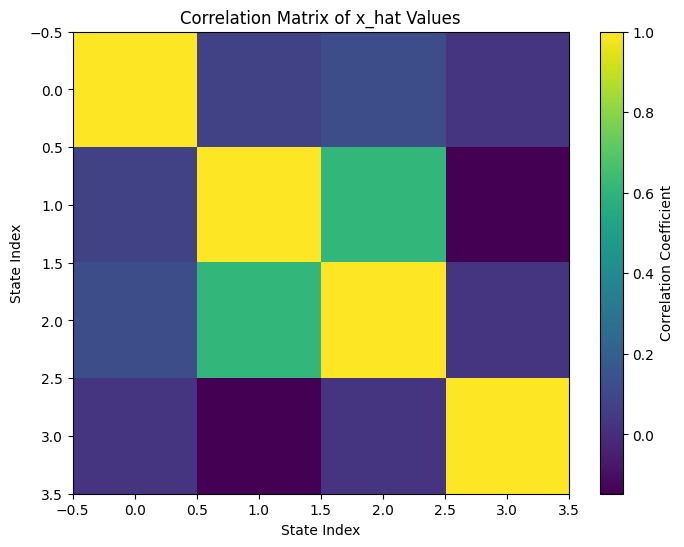

In [ ]:
# Check the shape of x_hat
print(x_hat.shape)

# Reshape or slice x_hat if necessary
if len(x_hat.shape) > 2:
    # Flatten the last dimensions if x_hat has extra dimensions
    x_hat_reshaped = x_hat.reshape(x_hat.shape[0], -1)
else:
    x_hat_reshaped = x_hat

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(x_hat_reshaped.T)

# Display the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title("Correlation Matrix of x_hat Values")
plt.xlabel("State Index")
plt.ylabel("State Index")
plt.show()

In [ ]:
# Adjust correlation threshold and decoupling factor
correlation_threshold = 0.6
decoupling_factor = 0.1
x_hat_reshaped = x_hat.reshape(x_hat.shape[0], -1)
# Step 1: Calculate correlation matrix
correlation_matrix = np.corrcoef(x_hat_reshaped.T)

# Step 2: Identify strong correlations
strong_pairs = identify_strong_correlations(correlation_matrix, threshold=correlation_threshold)
print(f"Strongly Correlated Pairs (Threshold {correlation_threshold}): {strong_pairs}")

if strong_pairs:
    # Step 3: Analyze dynamics
    analyze_system_dynamics(A, B, C, G, strong_pairs)

    # Step 4: Modify the model
    A_new, B_new, C_new, G_new = modify_model(A, B, C, G, strong_pairs, decoupling_factor=decoupling_factor)

    # Step 5: Confirm changes
    print("Changes to Model:")
    print("Original A:\n", A)
    print("Modified A:\n", A_new)

else:
    print("No strong correlations found to modify.")


Strongly Correlated Pairs (Threshold 0.6): [(1, 2, 0.6138698277805034)]
Analyzing System Dynamics for Strongly Correlated Pairs:

State Pair (1, 2) with Correlation 0.61:
  No strong coupling in A.
  Indices out of bounds for B.
  C maps these states: C[:,1] = [0. 1.], C[:,2] = [0. 0.]
  Indices out of bounds for G.
Changes to Model:
Original A:
 [[0.9 0.  1.  0. ]
 [0.  0.9 0.  1. ]
 [0.  0.  0.9 0. ]
 [0.  0.  0.  0.9]]
Modified A:
 [[0.9 0.  1.  0. ]
 [0.  0.9 0.  1. ]
 [0.  0.  0.9 0. ]
 [0.  0.  0.  0.9]]


In [ ]:
# Check initial state correlations
x0_correlation = np.corrcoef(x_hat_reshaped[0].T)
print("Correlation of Initial State (x0):\n", x0_correlation)

# Check input correlations
u_correlation = np.corrcoef(u[:, :, 0].T)
print("Correlation of Inputs (u_t):\n", u_correlation)

# Check noise correlations
w_correlation = np.corrcoef(w_array.T)
print("Correlation of Process Noise (w_t):\n", w_correlation)


Correlation of Initial State (x0):
 1.0
Correlation of Inputs (u_t):
 [[ 1.         -0.07290102]
 [-0.07290102  1.        ]]
Correlation of Process Noise (w_t):
 [[1.         0.07312984]
 [0.07312984 1.        ]]


Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'Correlation')

Text(0.5, 1.0, 'Correlation Over Time for State Pair (1, 2)')

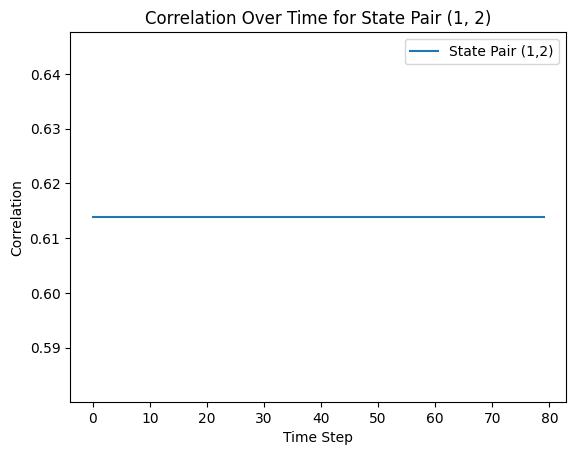

In [ ]:
# Compute correlations at each time step
time_step_correlations = []
for t in range(x_hat_reshaped.shape[0]):
    # Calculate correlation matrix for time step t
    corr_t = np.corrcoef(x_hat_reshaped.T)  # Should use all state variables over time, not a single time step
    time_step_correlations.append(corr_t)

# Visualize correlation over time for key state pairs
for i, j, _ in strong_pairs:
    correlations_over_time = [time_step_correlations[t][i, j] for t in range(len(time_step_correlations))]
    plt.plot(range(len(correlations_over_time)), correlations_over_time, label=f"State Pair ({i},{j})")
    plt.xlabel("Time Step")
    plt.ylabel("Correlation")
    plt.title(f"Correlation Over Time for State Pair ({i}, {j})")
    plt.legend()
    plt.show()


In [ ]:
print("A Matrix:\n", A)
print("B Matrix:\n", B)
print("C Matrix:\n", C)
print("G Matrix:\n", G)


A Matrix:
 [[0.9 0.  1.  0. ]
 [0.  0.9 0.  1. ]
 [0.  0.  0.9 0. ]
 [0.  0.  0.  0.9]]
B Matrix:
 [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]
C Matrix:
 [[1.  0.  0.  0. ]
 [0.  0.1 0.  0. ]]
G Matrix:
 [[0.06267323 0.38227793]
 [0.91741027 0.91629931]
 [0.91145586 0.64503692]
 [0.6805081  0.12463047]]


In [ ]:
# Define initial state for x_hat_new
new_w = np.random.multivariate_normal(mean=np.zeros(B.shape[1]), cov=np.eye(B.shape[1]), size=T)

# Adjust inputs for variability
new_u = np.array([
    [np.sin(t / 10), np.cos(t / 10)] for t in range(T)
]).reshape(T, 2, 1)

x0_new = np.random.multivariate_normal(mean=np.zeros(A.shape[0]), cov=np.eye(A.shape[0]))
x_hat_new = [x0_new]  # Initialize the list with the initial state

# Re-run simulation
for t in range(1, T + 1):
    calculate_x_next(t, x_hat_new, new_w, A, B, G, new_u)

# Convert x_hat_new to a numpy array for correlation analysis
x_hat_new_array = np.array(x_hat_new)

# Analyze new correlation
new_correlation_matrix = np.corrcoef(x_hat_new_array.T)
print("New Correlation Matrix:\n", new_correlation_matrix)



array([[ 0.95175136],
       [-0.33448395],
       [ 0.57239419],
       [-0.19629689]])

array([[ 1.81559543],
       [ 0.50597739],
       [ 1.48111451],
       [-0.57608475]])

array([[ 3.50225947],
       [ 0.95959051],
       [ 0.55600637],
       [-0.43604564]])

array([[ 4.09176515],
       [ 1.57407326],
       [ 2.18590395],
       [-0.74026402]])

array([[6.24499998],
       [1.87762585],
       [2.95278428],
       [0.35998996]])

array([[8.93881185],
       [3.29381143],
       [3.03721845],
       [0.25297352]])

array([[11.43304467],
       [ 4.49166706],
       [ 3.45332451],
       [ 1.85201063]])

array([[14.07582221],
       [ 7.18634728],
       [ 4.09539586],
       [ 3.24013582]])

array([[17.07493047],
       [11.00435009],
       [ 5.06792149],
       [ 3.86765016]])

array([[20.72208031],
       [15.05977817],
       [ 4.32069715],
       [ 4.21697405]])

array([[23.22985278],
       [19.03782716],
       [ 3.89902445],
       [ 4.23307367]])

array([[25.03514658],
       [22.60035071],
       [ 6.20333051],
       [ 4.59603185]])

array([[28.9318977 ],
       [26.12343788],
       [ 8.68081801],
       [ 4.10675938]])

array([[34.88217414],
       [28.74694064],
       [ 7.92311858],
       [ 4.52260273]])

array([[39.44381131],
       [31.45465179],
       [ 9.37251861],
       [ 4.9044147 ]])

array([[44.96150629],
       [34.1935299 ],
       [ 9.06156965],
       [ 5.14032618]])

array([[49.57840948],
       [36.80476668],
       [ 8.46558004],
       [ 4.41443765]])

array([[53.099045  ],
       [38.33043101],
       [ 7.72493001],
       [ 4.60445076]])

array([[55.48825034],
       [39.78707137],
       [ 6.30297261],
       [ 3.86997151]])

array([[56.17811914],
       [40.25025116],
       [ 6.588626  ],
       [ 4.71464162]])

array([[57.04683808],
       [41.3927514 ],
       [ 6.58056382],
       [ 5.05195787]])

array([[57.78382668],
       [42.63476113],
       [ 6.9182361 ],
       [ 6.50773349]])

array([[58.7493802 ],
       [45.08149824],
       [ 6.56655646],
       [ 6.91606005]])

array([[59.23303177],
       [47.56301783],
       [ 5.15551158],
       [ 7.04288174]])

array([[58.22568429],
       [49.79360129],
       [ 2.53646257],
       [ 7.02136658]])

array([[54.67082709],
       [51.65056489],
       [ 2.69586834],
       [ 7.80028552]])

array([[51.60435119],
       [53.9735536 ],
       [ 2.58834596],
       [ 7.95651912]])

array([[48.71344048],
       [56.09639937],
       [ 2.21739162],
       [ 7.12149201]])

array([[45.72029204],
       [57.05221533],
       [ 2.4358163 ],
       [ 5.70540935]])

array([[43.22789778],
       [56.38220465],
       [ 0.99193308],
       [ 3.93243668]])

array([[39.52743325],
       [53.89875637],
       [ 1.04032074],
       [ 3.06775377]])

array([[36.23566934],
       [50.69927418],
       [ 0.29528314],
       [ 3.26813506]])

array([[32.52210099],
       [47.92919198],
       [-1.18500397],
       [ 3.06567827]])

array([[27.69750877],
       [45.1524065 ],
       [-1.33575043],
       [ 2.04149659]])

array([[23.20640626],
       [41.55834989],
       [-2.16445103],
       [ 1.08711113]])

array([[18.34134316],
       [37.30973929],
       [-3.18552156],
       [-0.3151726 ]])

array([[12.95114215],
       [32.03592085],
       [-3.57027566],
       [-1.40802279]])

array([[ 7.72833581],
       [26.16111539],
       [-4.74433139],
       [-1.0904432 ]])

array([[ 1.87045423],
       [21.16847277],
       [-4.63718131],
       [-3.58983516]])

array([[-3.27438493],
       [14.16565533],
       [-3.64255094],
       [-4.04931799]])

array([[-6.88680216],
       [ 7.40654023],
       [-4.86860827],
       [-4.44446377]])

array([[-11.33775679],
       [  0.94401582],
       [ -5.33435655],
       [ -4.00809148]])

array([[-15.78037803],
       [ -4.40729545],
       [ -5.84052115],
       [ -5.34938444]])

array([[-20.25349713],
       [-10.52370239],
       [ -8.53360913],
       [ -6.74721528]])

array([[-26.93888309],
       [-17.37316584],
       [ -8.78994064],
       [ -6.3810112 ]])

array([[-33.17678297],
       [-23.10680868],
       [ -8.36445384],
       [ -8.09453784]])

array([[-38.32870978],
       [-29.90505326],
       [ -8.75974639],
       [ -9.09094296]])

array([[-43.32298952],
       [-36.93418249],
       [-10.47207138],
       [ -8.99226499]])

array([[-49.49174587],
       [-43.06674562],
       [-11.10867937],
       [-10.32151055]])

array([[-55.64152456],
       [-49.81199256],
       [-12.0872801 ],
       [-11.38467432]])

array([[-62.11631329],
       [-56.83527513],
       [-10.47674351],
       [ -9.95373329]])

array([[-66.29495672],
       [-61.60849207],
       [ -8.94558756],
       [ -8.83994109]])

array([[-68.48731398],
       [-64.66877283],
       [ -9.74457757],
       [ -8.32663348]])

array([[-71.22339596],
       [-66.7840869 ],
       [-10.18350119],
       [ -7.67399398]])

array([[-74.09036012],
       [-67.90704563],
       [ -9.64852571],
       [ -8.29890099]])

array([[-76.10315949],
       [-69.41315837],
       [ -9.57324048],
       [ -7.52601016]])

array([[-77.80916582],
       [-69.86633271],
       [ -7.4944189 ],
       [ -6.90610818]])

array([[-77.2380891 ],
       [-69.52616545],
       [ -7.62850137],
       [ -7.04469677]])

array([[-76.8333851 ],
       [-69.23307556],
       [ -7.15029147],
       [ -6.84692272]])

array([[-75.96921559],
       [-68.64984118],
       [ -6.44234187],
       [ -7.79132484]])

array([[-74.46509586],
       [-68.95271718],
       [ -6.55261418],
       [ -7.06905953]])

array([[-73.20673534],
       [-68.39265456],
       [ -7.49777956],
       [ -6.83954419]])

array([[-73.0080928 ],
       [-67.55602953],
       [ -5.178378  ],
       [ -5.37798233]])

array([[-70.50238384],
       [-65.24681389],
       [ -3.74052363],
       [ -3.88099006]])

array([[-66.8056919 ],
       [-61.58614447],
       [ -1.07790808],
       [ -4.07561228]])

array([[-60.81622062],
       [-58.41094245],
       [  0.52829165],
       [ -1.89892076]])

array([[-53.82352866],
       [-53.31226025],
       [  1.04667573],
       [ -1.26823003]])

array([[-47.01957831],
       [-48.04000214],
       [  1.76731266],
       [  0.2037724 ]])

array([[-40.18698866],
       [-41.78229654],
       [  1.79998978],
       [  1.1096104 ]])

array([[-34.02021362],
       [-35.21634157],
       [  3.47073976],
       [  1.55513183]])

array([[-26.81807683],
       [-28.84604922],
       [  4.54159943],
       [  2.27230705]])

array([[-19.2872958 ],
       [-22.39312393],
       [  4.55898298],
       [  2.82952442]])

array([[-12.51728223],
       [-16.03873618],
       [  3.98082028],
       [  3.04379887]])

array([[ -7.03032629],
       [-10.12881994],
       [  6.11680712],
       [  4.2212275 ]])

array([[ 0.01348536],
       [-3.6683858 ],
       [ 7.89546041],
       [ 4.11359263]])

array([[8.09889575],
       [1.99019792],
       [8.27039019],
       [5.82593915]])

array([[15.7161101 ],
       [ 8.73532594],
       [ 8.55228522],
       [ 5.04676285]])

array([[22.81734745],
       [13.95564824],
       [ 9.34098331],
       [ 5.63948888]])

array([[29.95980392],
       [19.16508553],
       [ 7.41056618],
       [ 4.99932256]])

array([[34.41941099],
       [23.12218687],
       [ 9.15649014],
       [ 4.29410153]])

New Correlation Matrix:
 [[1.         0.97717917 0.73786316 0.85942071]
 [0.97717917 1.         0.62297353 0.7910351 ]
 [0.73786316 0.62297353 1.         0.92185525]
 [0.85942071 0.7910351  0.92185525 1.        ]]


In [ ]:
correlation_threshold = 0.4
strong_pairs_new = identify_strong_correlations(correlation_matrix, threshold=correlation_threshold)
print(f"Strongly Correlated Pairs (New Threshold {correlation_threshold}): {strong_pairs_new}")


Strongly Correlated Pairs (New Threshold 0.4): [(1, 2, 0.6138698277805034)]


In [ ]:
x0_corr = np.corrcoef(x_hat_reshaped[0].T)
print("Initial Condition Correlation:\n", x0_corr)


Initial Condition Correlation:
 1.0


In [ ]:
A_new = A + np.random.normal(scale=0.01, size=A.shape)
print("Modified A Matrix:\n", A_new)


Modified A Matrix:
 [[ 8.89067730e-01 -1.98148129e-03  1.01847192e+00  1.41398865e-03]
 [-1.99699618e-02  9.30098495e-01  4.29916827e-03  1.01447545e+00]
 [-3.09360932e-02  5.25747360e-03  9.06927253e-01  3.56652870e-04]
 [-1.71468708e-02 -1.04773630e-02 -6.14644727e-03  9.08004159e-01]]


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[0] and Estimated x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

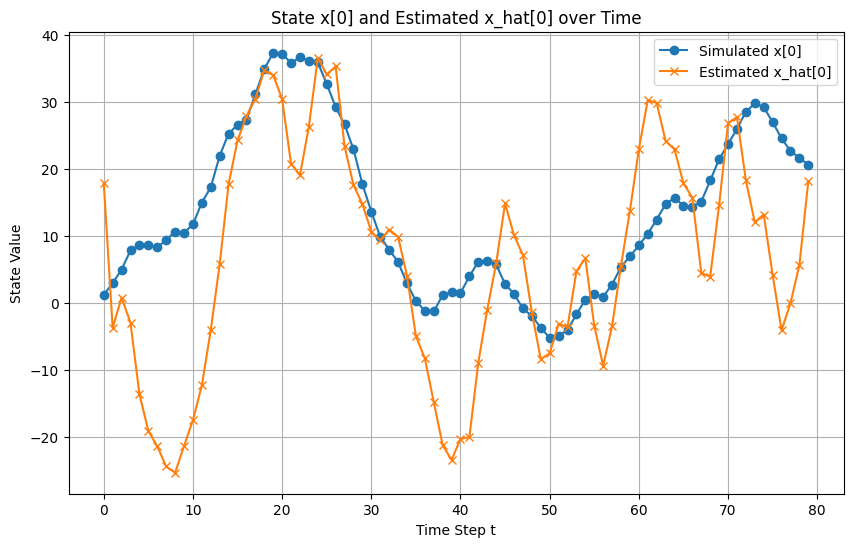

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[1] and Estimated x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

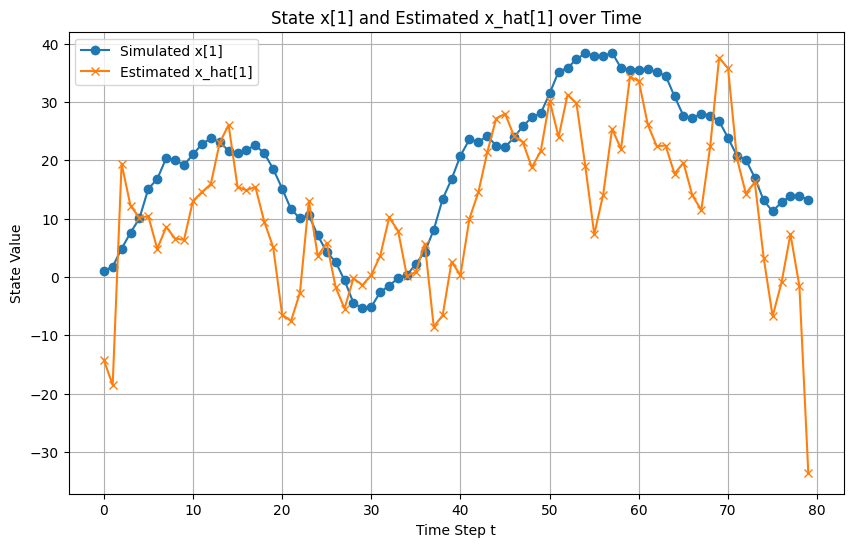

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[2] and Estimated x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

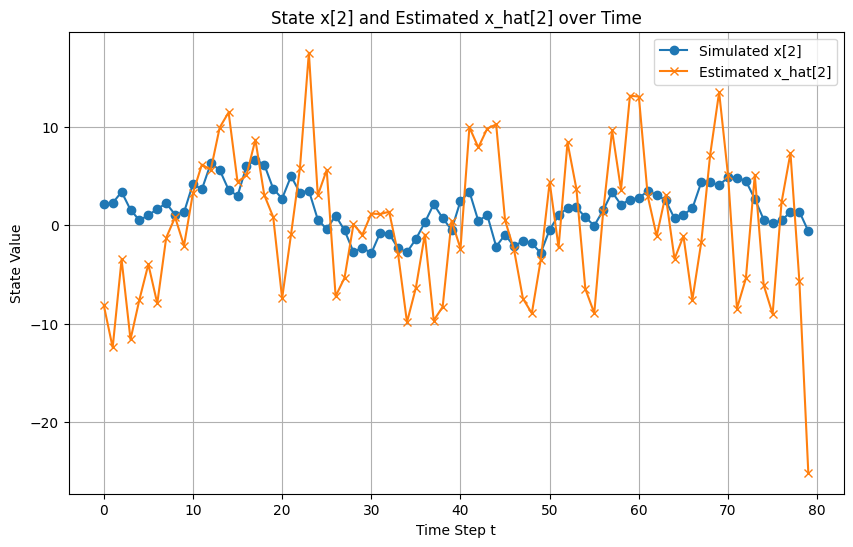

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[3] and Estimated x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

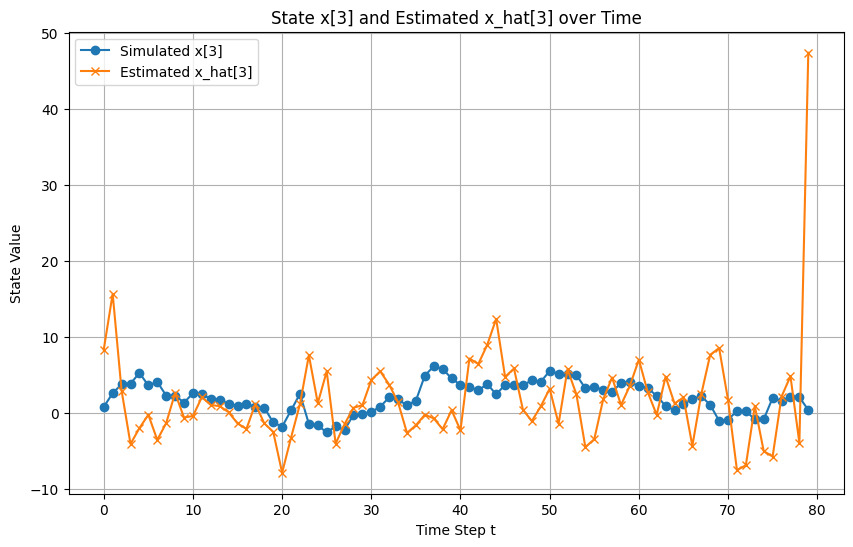

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x and x_hat are loaded or computed already and are numpy arrays
T = len(x_hat)  # Correct to define T based on the length of x_hat
t = np.arange(T)  # Time vector

# Ensure x_hat is a proper numpy array for slicing
x_hat = np.array(x_hat)  # Ensuring it's numpy array
x = np.array(x)  # Ensuring x is also a numpy array

# Loop through each state component for plotting
for i in range(x.shape[1]):  # This assumes x is 2D (time steps, state variables)
    plt.figure(figsize=(10, 6))

    # Plot simulated state (including all states)
    plt.plot(t, x[1:, i], label=f'Simulated x[{i}]', marker='o')

    # Plot estimated state (ensure x_hat matches dimensions)
    plt.plot(t, x_hat[:, i], label=f'Estimated x_hat[{i}]', marker='x')

    plt.title(f'State x[{i}] and Estimated x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('State Value')
    plt.legend()
    plt.grid(True)
    plt.show()